# CQF  Exam 3 

### Kieran Fitzpatrick

# Question 1

## 1. What is the cost function of Logistic Regression? Explain in Detail.

Logistic Regression is a widely used machine learning algorithm for binary classification problems. Whether it’s predicting if an email is spam or determining if a student will pass or fail an exam, logistic regression proves to be a valuable tool in the data scientist’s toolkit. Central to the success of logistic regression is the concept of a cost function, a crucial element that guides the model in its quest to find the optimal parameters for accurate predictions.

The cost function in logistic regression is designed to measure how well the model predicts the target variable compared to the actual values. The goal is to minimize this cost function to optimize the model’s parameters. The most commonly used cost function for logistic regression is the log loss (or cross-entropy loss) function.


### Sigmoid Function

The sigmoid function is used to map the input features $x$ to a probability value. This is defined as:

$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

Where $z = w \cdot x$, with $w$ being the weight vector and $x$ the input features.


### Probability Prediction

For a single training pair $(x, y)$:

$$
\hat{y} = P(Y = 1 \mid X = x) = \sigma(w \cdot x)
$$

Where $\hat{y}$ is the predicted probability, and $\sigma(z)$ is the sigmoid function.


### Cost Function for a Single Training Pair

The probability of $y$ given $x$ is:

$$
\begin{cases} 
\hat{y} & \text{if } y = 1 \\
1 - \hat{y} & \text{if } y = 0 
\end{cases}
$$

If the labels are 0 and 1, $Y$ is a Bernoulli random variable:
$$
P(Y \mid X = x) = \sigma(w \cdot x)^y [1 - \sigma(w \cdot x)]^{(1-y)}
$$

Taking the log of the probability:
$$
\text{log } P(y \mid x) = y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})
$$


### Loss Function

The negative log likelihood (or loss) for a single training pair is:

$$
L(\hat{y}, y) = -[y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]
$$

Maximising the log of probabilities is minimising the loss

### Binary Cross Entropy

Used with models that output a probability between 0 and 1, the cost function is given as below:

$$
J(W) = \log \left( \prod_{i=1}^n P(y^{(i)} \mid x^{(i)}) \right) = -\frac{1}{n} \sum_{i=1}^n \left[ y^{(i)}\log(\hat{y}^{(i)}) + (1 - y^{(i)})\log(1 - \hat{y}^{(i)}) \right]
$$

$$
= -\frac{1}{n} \sum_{i=1}^n \left[ y^{(i)}\log(f(x^{(i)}; w)) + (1 - y^{(i)})\log(1 - f(x^{(i)}; w)) \right]
$$

$$
= -\frac{1}{n} \sum_{i=1}^n \left[ y^{(i)}\log(\hat{p}^{(i)}) + (1 - y^{(i)})\log(1 - \hat{p}^{(i)}) \right]
$$

##### Convexity and Optimization
The binary cross-entropy loss function is convex, which means it has a single global minimum. This property makes it suitable for optimization algorithms like gradient descent.


#### Summary
Logistic regression uses the binary cross-entropy loss function to measure the difference between predicted probabilities and actual labels. The sigmoid function maps input features to probabilities. The loss function is convex, ensuring a unique global minimum, which can be found using gradient descent. This minimizes the error between predicted and actual values, leading to an optimized model.



# Question 2

##  What are voting classifiers in ensemble learning?


In ensemble learning, a voting classifier is a model that combines the predictions from multiple other models to make a final prediction. This technique is used to improve the predictive performance by capitalizing on the strengths of each individual model and mitigating their weaknesses.

There are two main types of voting classifiers:

- Hard Voting: In hard voting, each individual classifier makes a prediction (a vote) for each data point. The predictions by all the classifiers are then tallied, and the final output prediction is the class that gets the most votes. This method is straightforward and often effective; it works well when the classifiers are approximately equally good. Hard voting does not consider the confidence of the individual classifier's predictions; it simply counts votes.

- Soft Voting: In soft voting, each model's prediction is weighted by its confidence. This is typically implemented by using the predicted probabilities of the classes (for classifiers that can estimate class probabilities). The probabilities for each class are summed up across the classifiers, and the class with the highest summed probability is chosen as the final prediction. Soft voting often provides better performance than hard voting because it takes into account the confidence level of individual classifiers.

Voting classifiers are a powerful method in ensemble techniques, often used when the models in the ensemble are diverse (e.g., a combination of decision trees, SVMs, neural networks, etc.). This diversity helps in creating a more robust overall model with better generalization 
performance.


### Advantages of Voting Classifiers
- Improved Accuracy: By combining multiple models, voting classifiers can often achieve higher accuracy and generalization performance than any individual model.
- Robustness: Aggregating predictions reduces the impact of individual classifier errors, making the ensemble more robust to overfitting and variance.
- Versatility: Voting classifiers can combine different types of models (e.g., decision trees, logistic regression, SVMs), leveraging their diverse strengths.




# Question 3
Follow the 7-steps to model building for your selected ticker,
- (a) produce a model to predict positive moves (up trend) using Support Vector Machine (SVM)
model.
- (b) tune hyperparameters for the estimator and present the best model.
- (c) investigate the prediction quality using area under ROC curve, confusion matrix and classification report.

## Introduction

This project involves predicting short-term asset returns using machine learning techniques. Given the near-Normal nature of daily returns and the lack of significant correlation between consecutive returns, the task is particularly challenging. The focus is on applying supervised learning methods, particularly Support Vector Machine (SVM) models, to predict positive moves in the asset's price. The analysis will include comprehensive feature engineering, data pre-processing, and detailed model evaluation to ensure robust and meaningful predictions.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Base Libraries
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(rc={'figure.figsize': (20, 8)})
# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
train_test_split,
TimeSeriesSplit,
RandomizedSearchCV,
cross_val_score
)
# Metrics
from sklearn.metrics import (
accuracy_score,
classification_report,
RocCurveDisplay,
ConfusionMatrixDisplay,
log_loss
)
# Data Sources
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime


##  2.1 Collect & Load Data 


Using the SPY ticker which tracks the S&P 500. Building a model on the "market" as a whole is the most suitable as individual companies could have idiosyncratic risk that are not reflected in our model. We use Yahoo! Finance as data provider. To download the data, we import yfinance package. As we are predicting short-term return sign (for daily move), then training and testing over up to 5-year period should be sufficent.

In [2]:
# Fetch data by specifying the the start and end dates
SPY = yf.download('SPY', start='2014-01-01', end='2024-03-31', period = '1d')

SPY.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,152.196243,119636900
2014-01-03,183.229996,183.600006,182.630005,182.889999,152.171280,81390600
2014-01-06,183.490005,183.559998,182.080002,182.360001,151.730347,108028200
2014-01-07,183.089996,183.789993,182.949997,183.479996,152.662201,86144200
2014-01-08,183.449997,183.830002,182.889999,183.520004,152.695465,96582300


In [3]:
# Get Info
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2577 entries, 2014-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2577 non-null   float64
 1   High       2577 non-null   float64
 2   Low        2577 non-null   float64
 3   Close      2577 non-null   float64
 4   Adj Close  2577 non-null   float64
 5   Volume     2577 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.9 KB


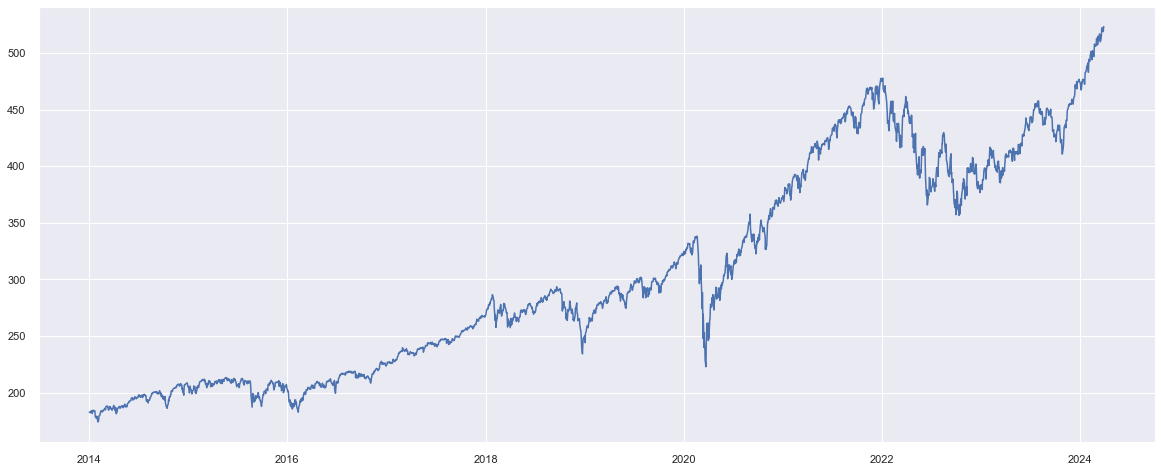

In [4]:
# Visualize data
plt.plot(SPY['Close']);

#   2.2 EDA of Original dataset 

In this step, we conduct an exploratory data analysis (EDA) to understand the basic statistical properties of the dataset. This helps in gaining insights into the data distribution and identifying any potential anomalies or patterns.

In [5]:
# Descriptive statistics
SPY.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2577.0,3.047836e+02,9.360393e+01,1.747800e+02,2.131400e+02,2.811100e+02,3.944700e+02,5.233900e+02
High,2577.0,3.064488e+02,9.419531e+01,1.755600e+02,2.140700e+02,2.829900e+02,3.973000e+02,5.246100e+02
Low,2577.0,3.029916e+02,9.299445e+01,1.737100e+02,2.125000e+02,2.799300e+02,3.918900e+02,5.227800e+02
Close,2577.0,3.048435e+02,9.364676e+01,1.741700e+02,2.131700e+02,2.813400e+02,3.951200e+02,5.231700e+02
Adj Close,2577.0,2.840290e+02,1.013184e+02,1.449160e+02,1.868762e+02,2.578667e+02,3.847358e+02,5.231700e+02
Volume,2577.0,9.226123e+07,4.584706e+07,2.027000e+07,6.287170e+07,8.044470e+07,1.068980e+08,5.072443e+08


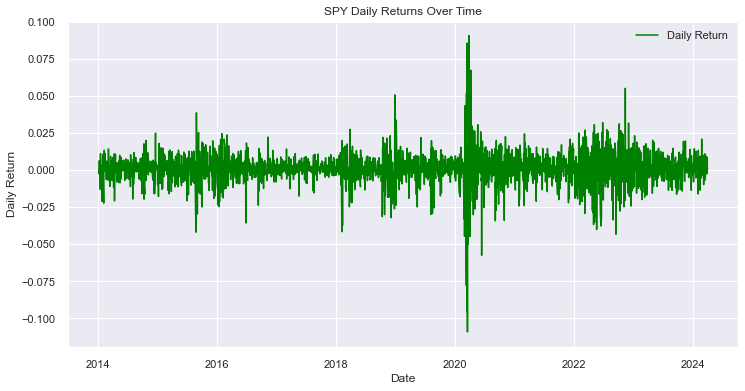

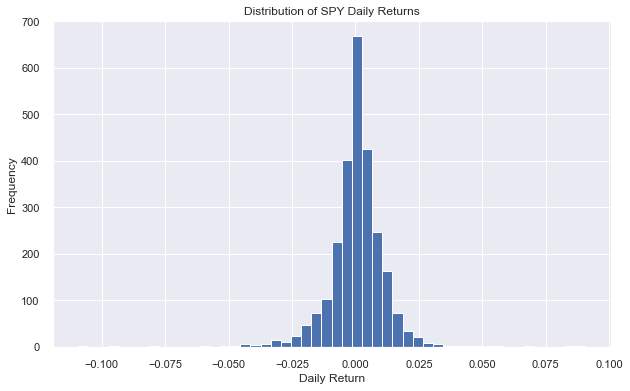

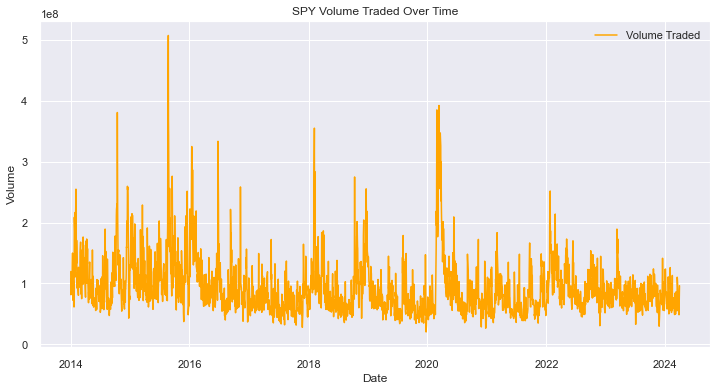

In [6]:
# Calculate daily returns
Daily_Return = SPY['Adj Close'].pct_change()

# Plot the daily 
plt.figure(figsize=(12, 6))
plt.plot(Daily_Return, label='Daily Return', color='green')
plt.title('SPY Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

# Plot the distribution of daily returns
plt.figure(figsize=(10, 6))
Daily_Return.hist(bins=50)
plt.title('Distribution of SPY Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# Plot the volume 
plt.figure(figsize=(12, 6))
plt.plot(SPY['Volume'], label='Volume Traded', color='orange')
plt.title('SPY Volume Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

The near-normal distribution of daily returns, centered around zero, highlights the challenge in predicting significant market movements:

- Minimal Deviation: Most returns are close to zero, indicating little daily movement and difficulty in predicting large swings.
- Efficient Market: The balanced nature of positive and negative returns suggests that past data may not reliably predict future movements.
- Noise Over Signal: The prevalence of minor fluctuations makes it challenging to distinguish meaningful patterns from random noise, complicating prediction efforts.

Overall, the distribution suggests that market prices follow a random walk, making them inherently difficult to predict using historical data alone.

The spike in return volatility and increased trading volumes in 2020 are likely due to market responses to the COVID-19 pandemic:

- Increased Volatility: Indicates rapid changes in investor sentiments, leading to larger daily price movements.
- Higher Trading Volumes: Reflects heightened trading as investors adjust portfolios in response to fluctuating market conditions, typical in periods of uncertainty.

These trends highlight how external shocks can dramatically affect market dynamics and investor behavior. We will take this into consideration during our feature engineering

#  2.3 Clean Data 
Data is already cleaned. No further processing or imputation required.

In [7]:
# check for missing values
SPY.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

##  3  Feature Specification 

Features are also known as an independent variable which are used to determine the value of the
target variable. We will create features and target (label) from the raw dataset.

Logarithmic returns of the SPY ticker and create a binary feature indicating the direction of the returns. This binary feature indicates the direction of the return. If the logarithmic return is positive, the sign is 1, otherwise it is 0. This feature will be used as the target variable in the classification model to predict whether the return for the next period will be positive or not. These features will be crucial for building the predictive model, as they represent the primary information about the asset's performance that we aim to predict. We have also included lagged returns from up to 3 previous days.

In [8]:
#Calculate  Returns
SPY['RET'] = np.log(SPY['Close'] / SPY['Close'].shift(1))
# Sign of return or momentum (binary feature: 1 if positive, 0 if not)
SPY['Sign'] = np.where(SPY['RET'] > 0, 1, 0)

In [9]:
lags = 3
cols = []
for lag in range(1, lags+1):
    col_ret = 'ret_%d' % lag
    SPY[col_ret] = SPY['RET'].shift(lag)
    cols.append(col_ret)

Below features cover various aspects of price and volume dynamics, helping capture the underlying patterns in the data.

In [10]:
#create features


# Calculate Open - Close
SPY['OC'] = SPY['Close'] / SPY['Open'] - 1
# Calculate High - Low (intraday price range)
SPY['HC'] = SPY['High'] / SPY['Low'] - 1
# Calculate Gap
SPY['GAP'] = SPY['Open'] / SPY['Close'].shift(1) - 1
# Volume change percentage
SPY['VCHG'] = SPY['Volume'].pct_change()
# Simple moving average
SPY['MA'] = SPY['Close'] / SPY['Close'].rolling(7).mean()
# Exponential moving average
SPY['EMA'] =  SPY['Close']/SPY['Close'].ewm(span=(7), adjust=False).mean()
# Volume moving average
SPY['VMA'] = SPY['Volume'] / SPY['Volume'].rolling(7).mean()
# Standard deviation
SPY['STD'] = SPY['RET'].rolling(5).std()


SPY.dropna(inplace=True)

#### Price Range Features: 

- Calculating Open-Close (OC) and High-Low (HC) ratios is suitable for capturing daily price movements and volatility.

- Gap Feature: This feature captures overnight price changes and is crucial for markets that are not open 24/7, providing insights into off-market sentiment changes.

- Volume Changes: The percentage change in volume (VCHG) is a good indicator of trading activity and can reflect increased interest or disinterest in the asset.

- Moving Averages: Both simple (MA) and exponential (EMA) moving averages are crucial for smoothing out price data and identifying trends. The choice of a 7-day window is typical and offers a short-term perspective.

- Volume Moving Average (VMA): Averaging volume over a period helps understand longer-term volume trends, which is valuable for confirming trends indicated by price movements.

- Standard Deviation of Returns (STD): This feature is vital for measuring the volatility of returns over a given period, which can be a critical predictor in financial models.

In [11]:
SPY.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RET', 'Sign',
       'ret_1', 'ret_2', 'ret_3', 'OC', 'HC', 'GAP', 'VCHG', 'MA', 'EMA',
       'VMA', 'STD'],
      dtype='object')

#### Economic Indicators

In this step, we enhance the dataset by including external economic indicators, specifically the Treasury 2-year and 10-year rates. These indicators can provide additional context about the market conditions. Interest rates have major impact on stock market returns as they refelct conditions in the broader economy.

- 2-year Rate: Reflects short-term economic conditions. Higher rates often hurt stocks due to increased borrowing costs.

- 10-year Rate: Indicates long-term outlook. Rising rates can lower stock values by increasing discount rates but may signal economic growth, which can be positive for stocks.

In [12]:
#dates for the data retrieval - same as SPY index
start = datetime(2014, 1, 1)
end = datetime(2024, 3, 31)

#  data for the Treasury 2-year rate
treasury_2yr = pdr.get_data_fred('DGS2', start, end)

#  data for the Treasury 10-year rate
treasury_10yr = pdr.get_data_fred('DGS10', start, end)

In [13]:
# Merge the interest rate data with the SPY DataFrame using the date to join
SPY = SPY.join(treasury_2yr, how='left')
SPY = SPY.join(treasury_10yr, how='left')

# fill NaN values that might be created during the join if there are missing data points
SPY.fillna(method='ffill', inplace=True)  

In [14]:
# Calculate daily changes
SPY['Change_2yr'] = SPY['DGS2'].diff(1)  # Calculates the difference from the previous row
SPY['Change_10yr'] = SPY['DGS10'].diff(1)

In [15]:
SPY.dropna(inplace=True)

Dropping the original columns as no longer need them and have derived all necessary features.

In [16]:
SPY.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'DGS2', 'DGS10'  ], axis=1, inplace=True)

##  4 Label and Feature Selection   

The label or target variable, known as 'Label', is generated to predict the sign of the return for the next trading day. This label is binary, where +1 indicates a positive return (i.e., the next day’s closing price is higher than today’s), and 0 otherwise. The 'Label' is constructed by shifting the 'sign' column, which contains binary indicators of positive returns, backwards by one day. This setup allows us to use today's data to predict whether tomorrow's return will be positive.
We assign a value of +1 for the buy signal and 0 otherwise. The target can be described as :

$$
y_t = \begin{cases} 
+1 & \text{if } p_{t-1} > 0 \\
0 & \text{otherwise} 
\end{cases}
$$

where $p_t$ is the current closing price of the underlying and $p_{t+1}$ is the 1-day forward closing price of underlying

### Creation of a target label 

The 'Label' column is created to be used as the target variable for predicting the next day's return direction. The 'Sign' column is removed after creating the 'Label' to avoid redundancyand data leakage.

In [17]:
SPY['Label'] = SPY['Sign'].shift(-1)
SPY.dropna(inplace=True)

In [18]:
SPY['Ret+1'] = SPY['RET'].shift(-1)
SPY.dropna(inplace=True)

In [19]:
SPY = SPY.drop(["Sign"], axis=1)

In [20]:
# label
y = SPY['Label'] # object to predict
y

Date
2014-01-13    1.0
2014-01-14    1.0
2014-01-15    0.0
2014-01-16    0.0
2014-01-17    1.0
             ... 
2024-03-20    1.0
2024-03-21    0.0
2024-03-22    0.0
2024-03-25    0.0
2024-03-26    1.0
Name: Label, Length: 2568, dtype: float64

In [21]:
# Check Class Imbalance
pd.Series(y).value_counts()

1.0    1395
0.0    1173
Name: Label, dtype: int64

In [22]:
# features
display(SPY.shape)


(2568, 16)

###  4.2 Feature Selection

Reduce the number of input variables that are believed to be most useful to a model. We use
correlation measures which is one the filter methods to address multicollinearity among features.

In [23]:
SPY.describe().T

,count,mean,std,min,25%,50%,75%,max
RET,2568.0,0.000403,0.011062,-0.115887,-0.003792,0.000582,0.005710,0.086731
ret_1,2568.0,0.000405,0.011062,-0.115887,-0.003792,0.000586,0.005710,0.086731
ret_2,2568.0,0.000406,0.011062,-0.115887,-0.003792,0.000588,0.005710,0.086731
ret_3,2568.0,0.000407,0.011062,-0.115887,-0.003792,0.000588,0.005710,0.086731
OC,2568.0,0.000218,0.008111,-0.056612,-0.003126,0.000508,0.004158,0.047994
HC,2568.0,0.011249,0.008801,0.001230,0.005819,0.008798,0.013537,0.092387
GAP,2568.0,0.000244,0.007117,-0.104485,-0.002263,0.000465,0.003273,0.060376
VCHG,2568.0,0.053193,0.358788,-0.687448,-0.187186,-0.005886,0.226829,2.360032
MA,2568.0,1.001253,0.013976,0.869298,0.995682,1.002579,1.008784,1.086135
EMA,2568.0,1.001191,0.011624,0.887653,0.996680,1.002726,1.007575,1.055093


####  Visual inspection and correlation analysis

Let visually investigate some relationships in our data. For example, we can simply look at the relationship return on T+1  with all other predictors.

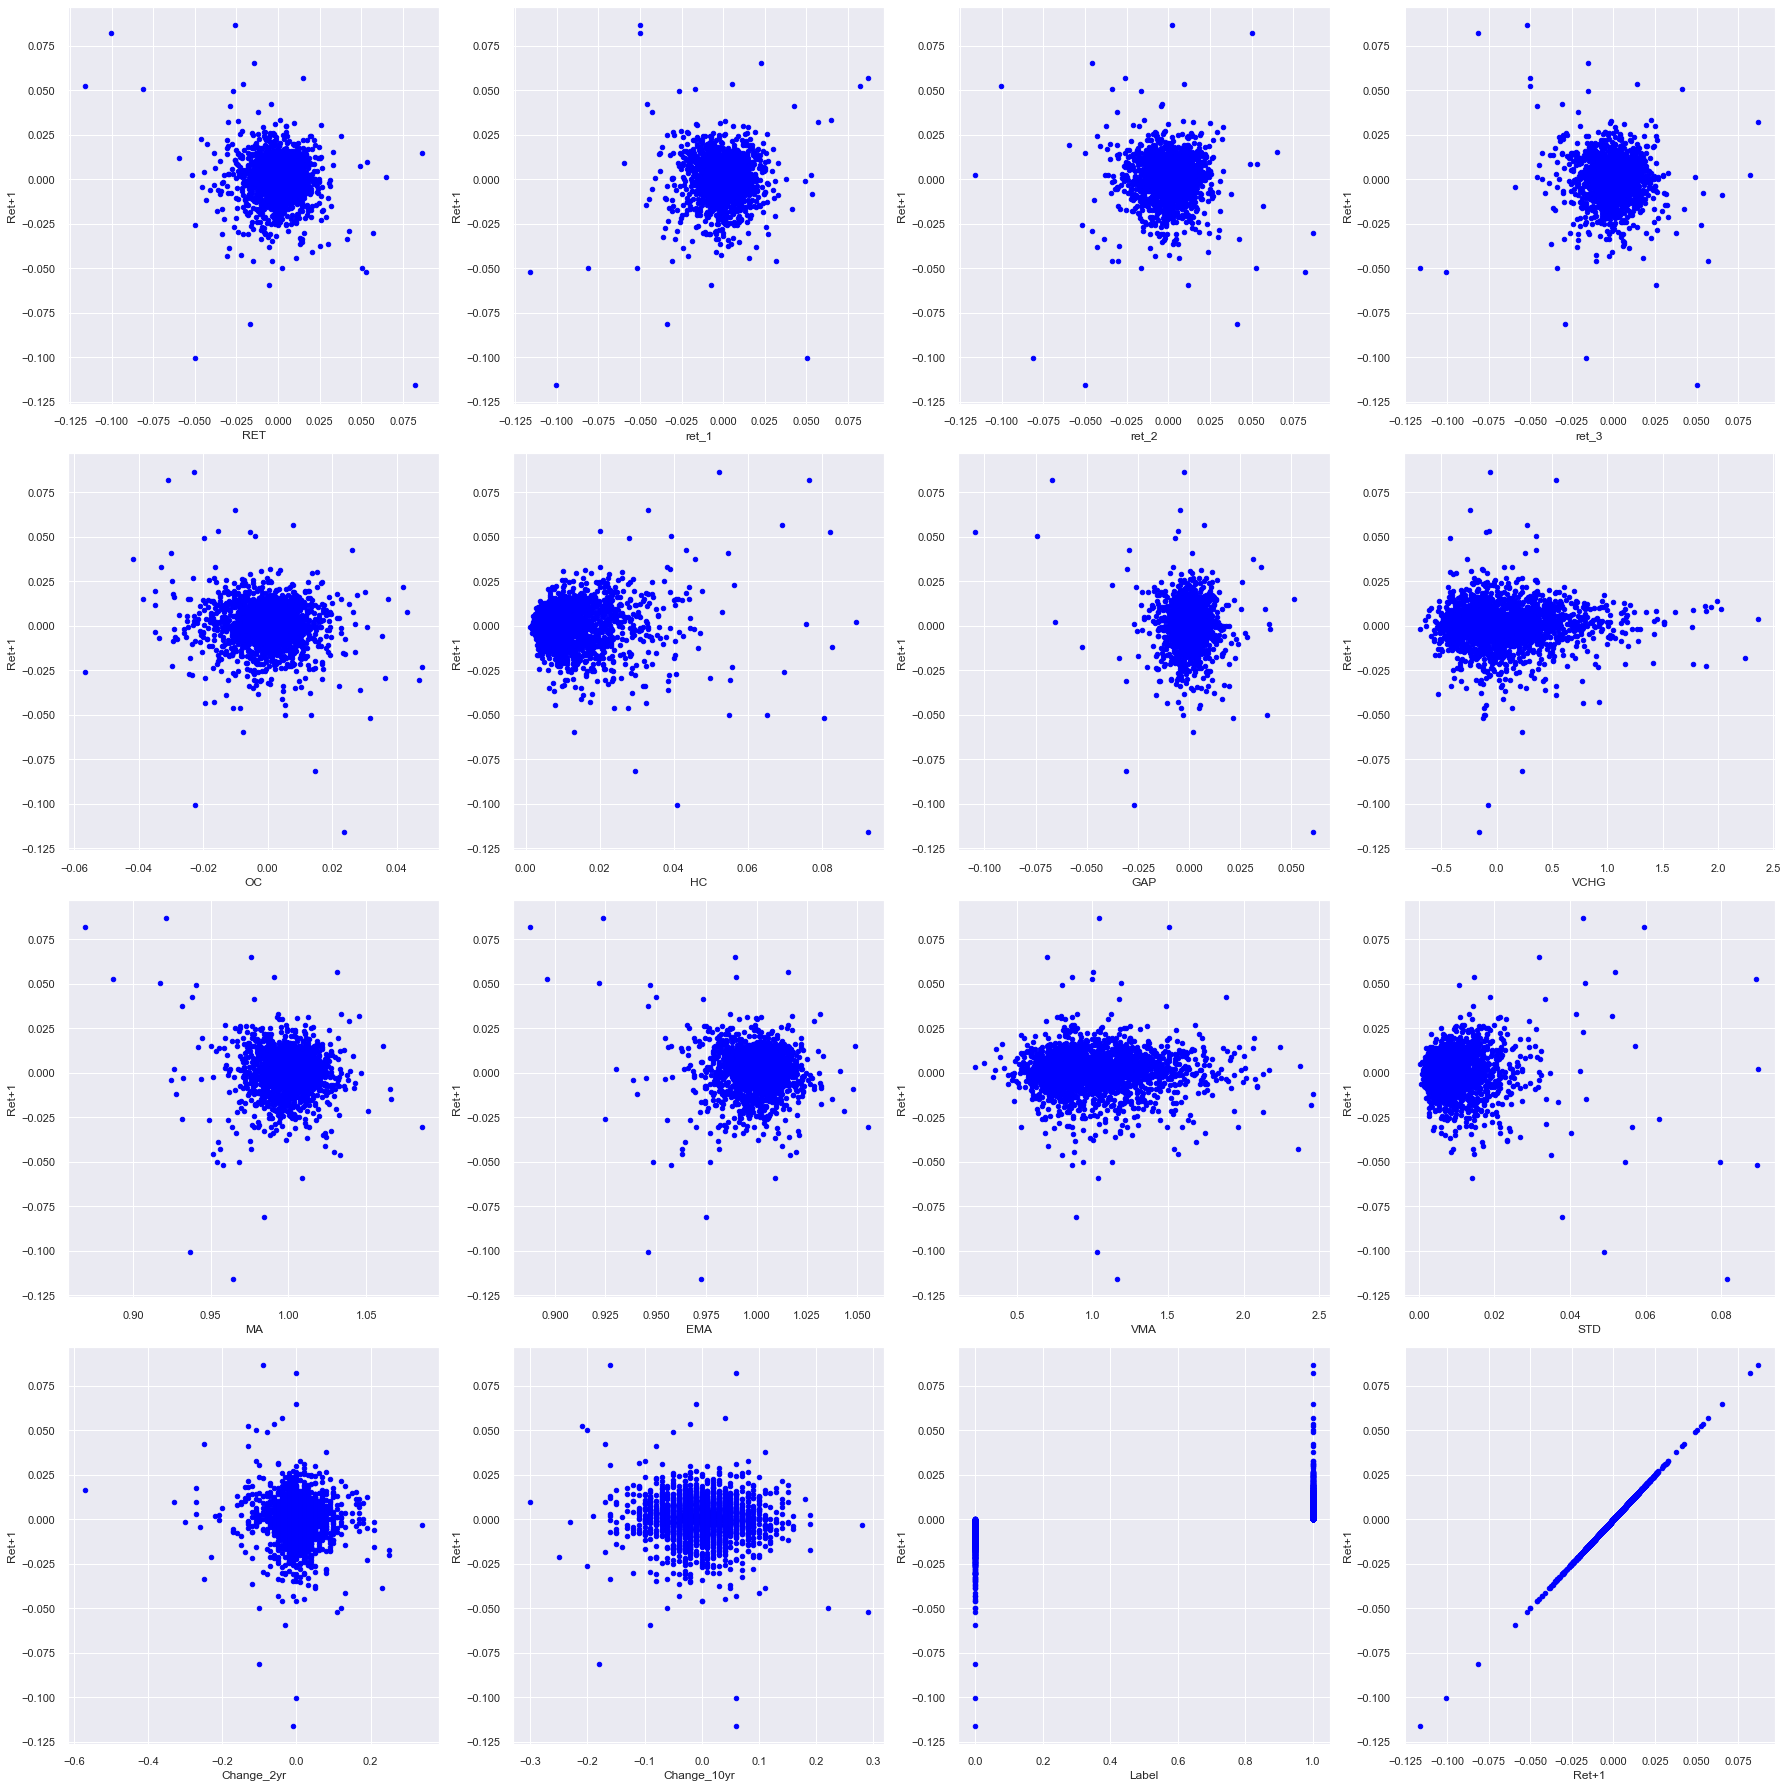

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 25))
axes = axes.flatten()  

for idx, feature in enumerate(SPY.columns):
    SPY.plot(kind='scatter', x=feature, y='Ret+1', ax=axes[idx], color='blue')  
plt.tight_layout()  
plt.show()

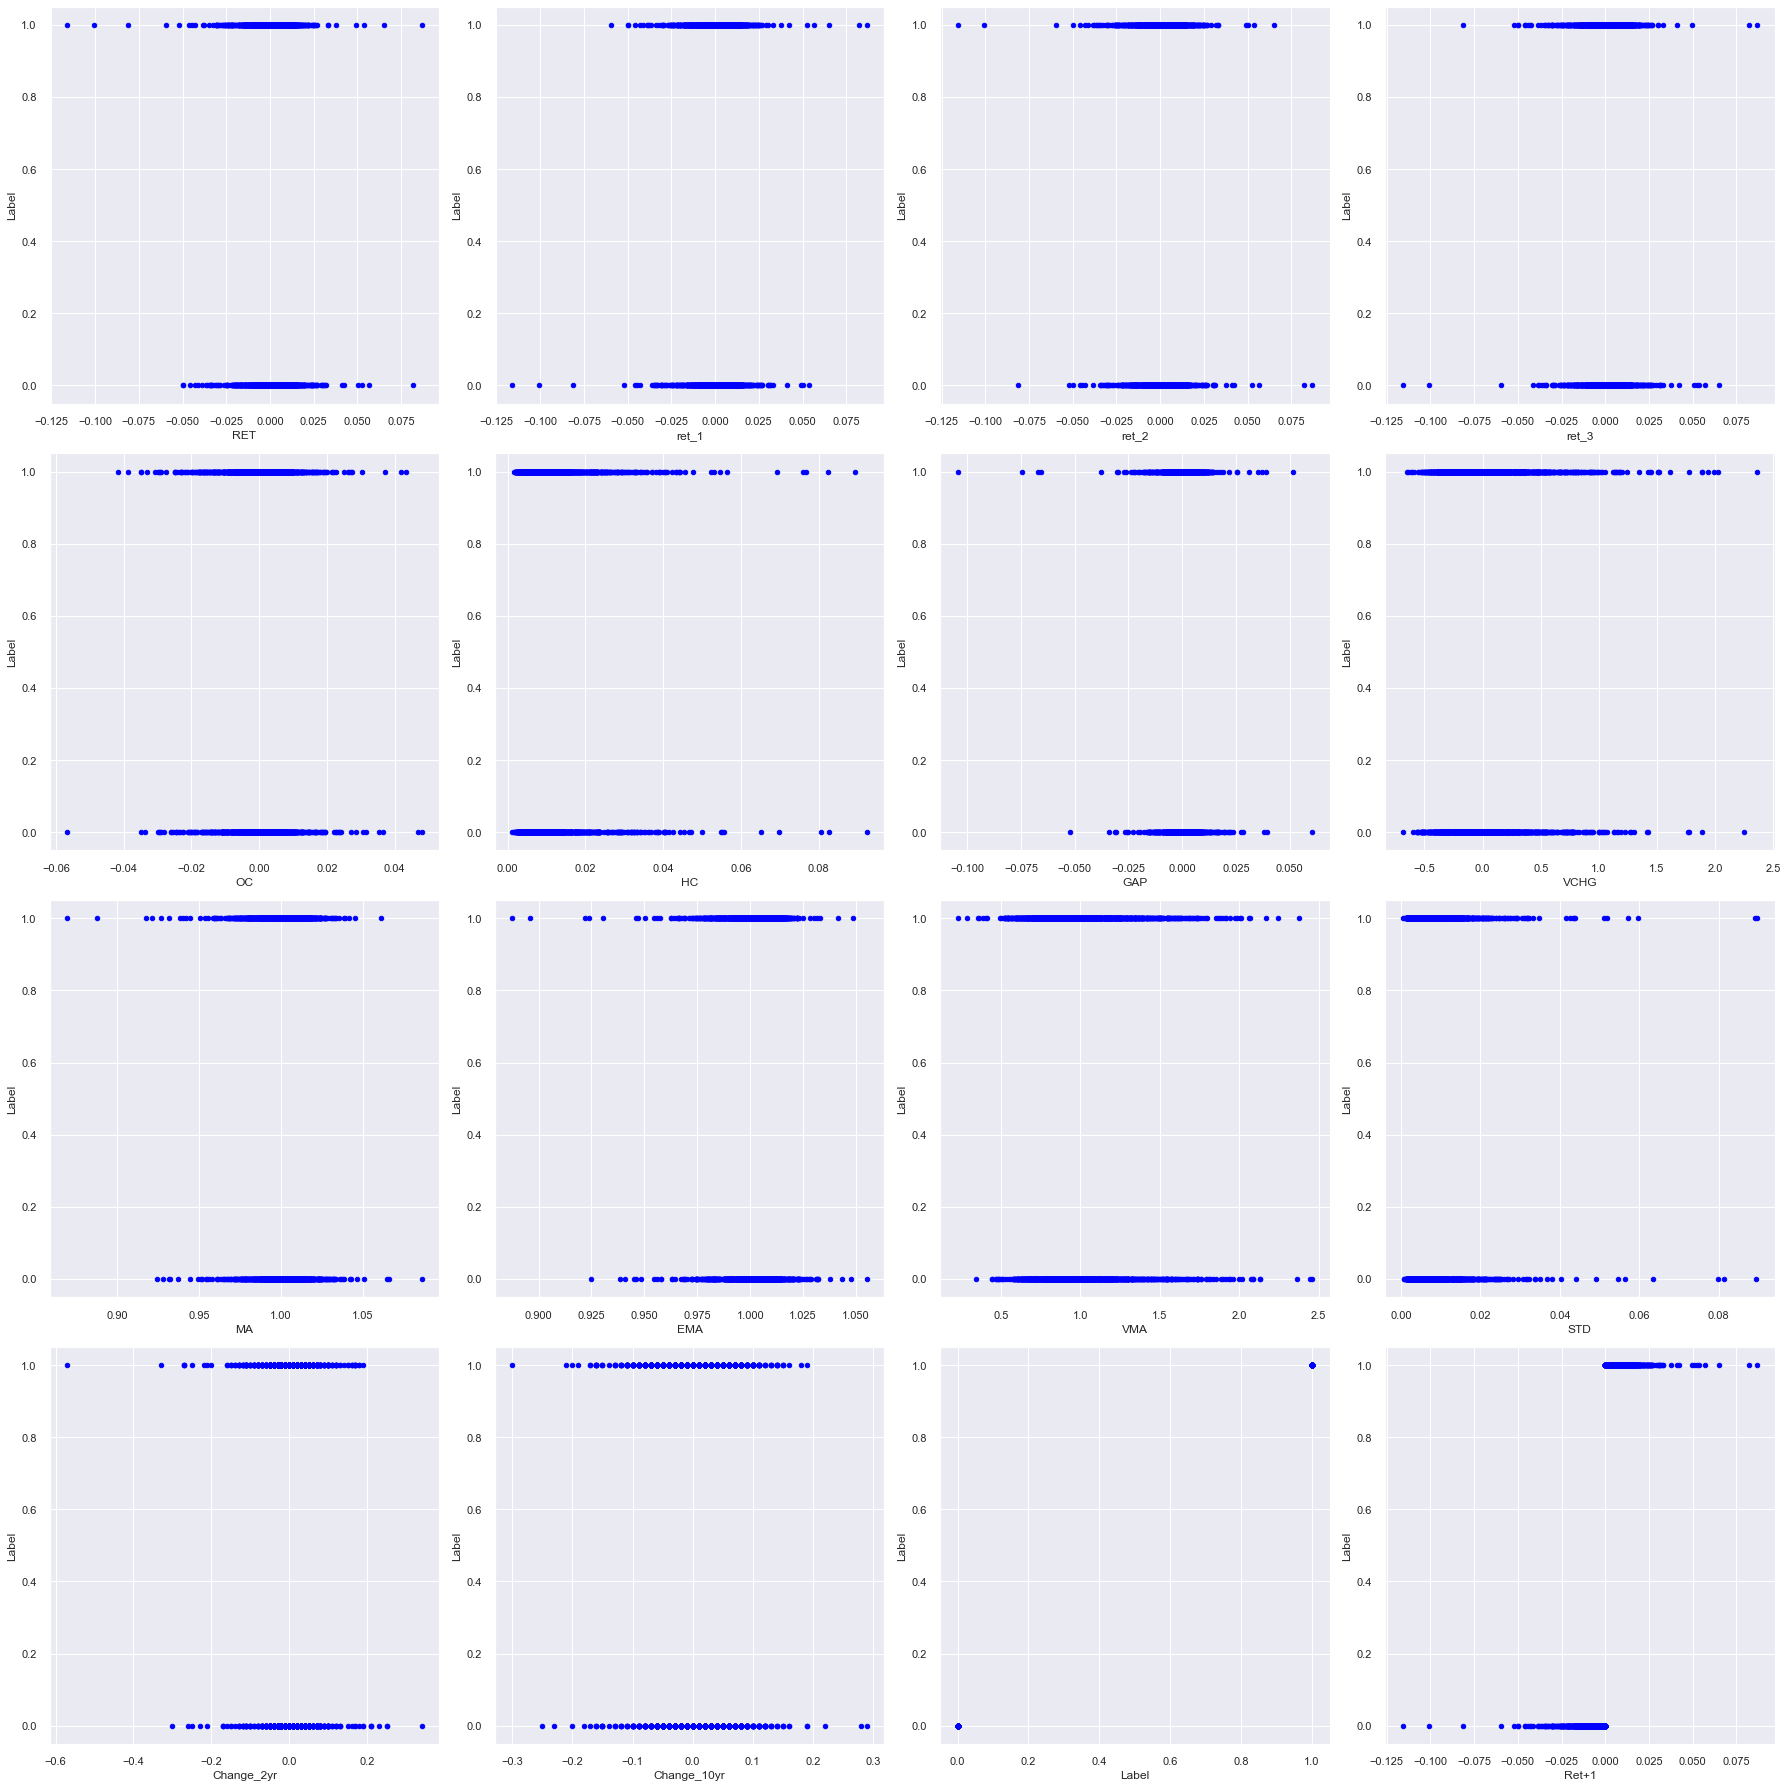

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 25))
axes = axes.flatten()  

for idx, feature in enumerate(SPY.columns):
    SPY.plot(kind='scatter', x=feature, y='Label', ax=axes[idx], color='blue')  
plt.tight_layout()  
plt.show()

The scatter plots generally reveal that most features show a dispersed or cloud-like pattern relative to the binary target Label and the return at t+1, which indicates the absence of a clear linear relationship or a distinct boundary that separates the classes (positive vs. non-positive returns). This was expected given the normal distribution of the daily returns and the inherent randomness. 

Reduce the number of input variables that are believed to be most useful to a model. We use
correlation measures which is one the filter methods to address multicollinearity among features.

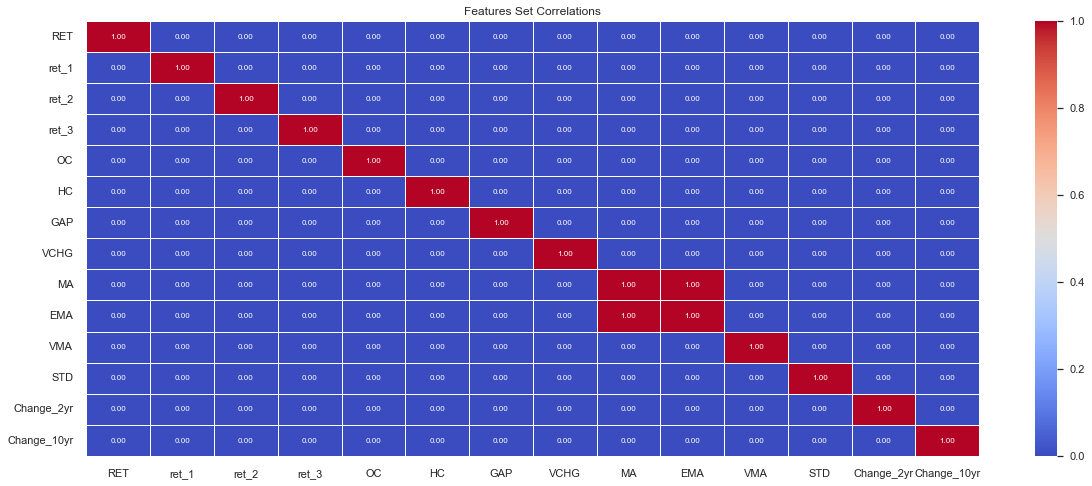

In [26]:
# drop label from dataframe
SPY.drop(['Label', 'Ret+1'], axis=1, inplace=True)

# remove features that are highly correlated
sns.heatmap(SPY.corr()>0.85,
            annot=True,
            annot_kws={"size": 8},
            fmt=".2f",
            linewidth=.5,
            cmap="coolwarm",
            cbar=True); #cmap="crest", virids, magma

plt.title('Features Set Correlations');

The moving averages (MA and EMA) are also highly correlated with each other, indicating redundancy. Both are derived from the close prices but apply different smoothing techniques. We will remove one to avoid pverfitting. 

In [27]:
# remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.85):
    col_corr = set()
    corr_matrix = SPY.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [28]:
#total correlated features
drop_correlated_features = correlated_features(SPY)

# drop the highly correlated features
features = SPY.drop(drop_correlated_features, axis=1)



In [29]:
# Specify X
X = features

In [30]:
X.columns

Index(['RET', 'ret_1', 'ret_2', 'ret_3', 'OC', 'HC', 'GAP', 'VCHG', 'MA',
       'VMA', 'STD', 'Change_2yr', 'Change_10yr'],
      dtype='object')

In [31]:
# Get the count of rows in X and y
num_rows_X = X.shape[0]
num_rows_y = y.shape[0]

print(f"Number of rows in X: {num_rows_X}")
print(f"Number of rows in y: {num_rows_y}")

Number of rows in X: 2568
Number of rows in y: 2568


####  4.3 EDA for Feature Scaling

The choice of scaling techniques to be used should come from the Exploratory Data Analysis of
features set.

In [32]:
# decide which scaling to use
X.describe().T

,count,mean,std,min,25%,50%,75%,max
RET,2568.0,0.000403,0.011062,-0.115887,-0.003792,0.000582,0.005710,0.086731
ret_1,2568.0,0.000405,0.011062,-0.115887,-0.003792,0.000586,0.005710,0.086731
ret_2,2568.0,0.000406,0.011062,-0.115887,-0.003792,0.000588,0.005710,0.086731
ret_3,2568.0,0.000407,0.011062,-0.115887,-0.003792,0.000588,0.005710,0.086731
OC,2568.0,0.000218,0.008111,-0.056612,-0.003126,0.000508,0.004158,0.047994
HC,2568.0,0.011249,0.008801,0.001230,0.005819,0.008798,0.013537,0.092387
GAP,2568.0,0.000244,0.007117,-0.104485,-0.002263,0.000465,0.003273,0.060376
VCHG,2568.0,0.053193,0.358788,-0.687448,-0.187186,-0.005886,0.226829,2.360032
MA,2568.0,1.001253,0.013976,0.869298,0.995682,1.002579,1.008784,1.086135
VMA,2568.0,1.005360,0.277821,0.226187,0.811824,0.956223,1.152399,2.457820


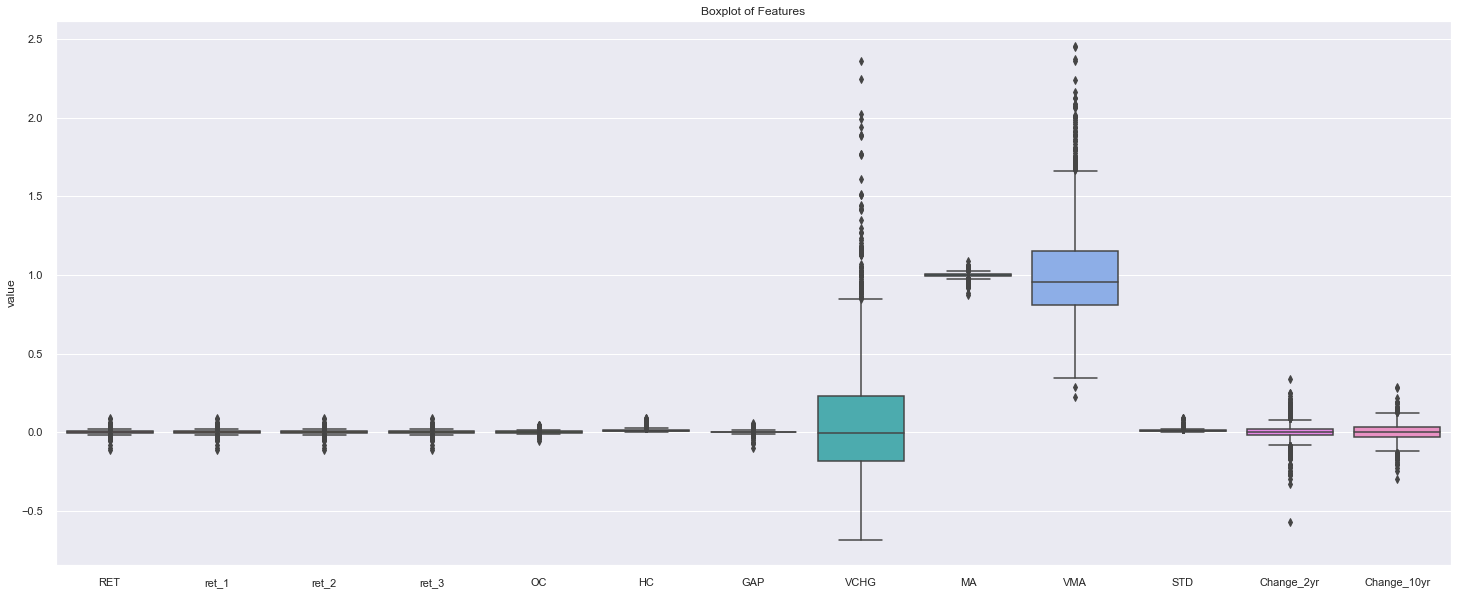

In [33]:
#study the distribution
fig, ax = plt.subplots(figsize=(25,10))
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of Features');

##  5 Base Model  

We now build a base model with default parameters using Pipelines. Dataset needs to be scaled
for the model to work properly and all the features should have a similar scale. The scaling can be
accomplished by using the StandardScaler. shuffle=False parameter to maintain the temporal order of the data, which is crucial for time series analysis. We will create a basic Logistic Regression model first and then move onto the SVM for comparison

Split Data

In [34]:
# Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

In [35]:
# Define a Baseline Model
lr_classifier = Pipeline([
("scaler", StandardScaler()),
("lr_classifier", LogisticRegression(class_weight='balanced'))
])
lr_classifier.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lr_classifier', LogisticRegression(class_weight='balanced'))])

- StandardScaler: This step ensures that all features are scaled to have a mean of 0 and a standard deviation of 1, which is important for models like Logistic Regression.
- Logistic Regression: The LogisticRegression model is used with class_weight='balanced', which helps handle any class imbalance by adjusting the weights inversely proportional to class frequencies.

In [36]:
# Verify Class Labels
lr_classifier.classes_

array([0., 1.])

In [37]:
# Predict the Class Labels
y_train_pred = lr_classifier.predict(X_train)
y_test_pred = lr_classifier.predict(X_test)
y_test_pred[-20:]

array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 1.])

In [38]:
pd.Series(y_test_pred).value_counts()

0.0    284
1.0    230
dtype: int64

In [39]:
# Predict Probabilities
y_proba = lr_classifier.predict_proba(X_test)
y_proba[-20:]

array([[0.45063698, 0.54936302],
       [0.50970909, 0.49029091],
       [0.50408939, 0.49591061],
       [0.53282731, 0.46717269],
       [0.43222404, 0.56777596],
       [0.53168256, 0.46831744],
       [0.50447765, 0.49552235],
       [0.46993264, 0.53006736],
       [0.52627184, 0.47372816],
       [0.5597745 , 0.4402255 ],
       [0.51092766, 0.48907234],
       [0.52040294, 0.47959706],
       [0.52978802, 0.47021198],
       [0.5484025 , 0.4515975 ],
       [0.47906336, 0.52093664],
       [0.45550061, 0.54449939],
       [0.50508658, 0.49491342],
       [0.45881078, 0.54118922],
       [0.49772668, 0.50227332],
       [0.47852876, 0.52147124]])

The probabilities are fairly close to 0.5, indicating that the model is somewhat uncertain in its predictions, which could suggest the need for further model tuning or exploration. This balance in the predictions is a good sign that the class weighting is effective, and the probabilities reflect a model that isn't overly confident, which can be realistic for financial data

In [40]:
 # Get the Scores
acc_train_lr = accuracy_score(y_train, y_train_pred)
acc_test_lr = accuracy_score(y_test, y_test_pred)
print(f'Baseline Model -- Train Accuracy: {acc_train_lr:0.4}, Test Accuracy:{acc_test_lr:0.4}')

Baseline Model -- Train Accuracy: 0.5239, Test Accuracy:0.5117


The accuracy scores for the Logistic Regression baseline model show that it performs similarly on both the training and testing datasets, with a training accuracy of about 52.39% and a testing accuracy of 51.17%. The close accuracy scores suggest that the model isn't overfitting, which is good. However, the accuracies are only slightly better than a random guess in a binary classification task.

#### Prediction Quality

<strong> Confusion Matrix   </strong>

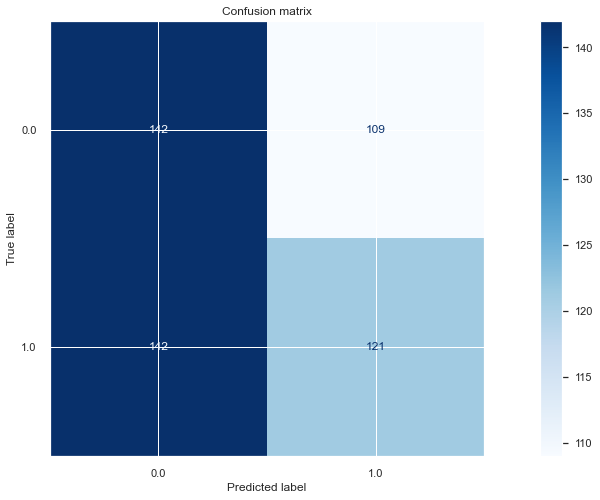

In [41]:
# Display confussion matrix
disp_lr = ConfusionMatrixDisplay.from_estimator(
lr_classifier,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

The model correctly predicts positive and negative classes but struggles with a high number of false positives, indicating an inclination to over-predict positive returns. The model seems better at predicting true positives and true negatives than avoiding false positives and false negatives.
The relatively high number of false positives might suggest that the model is somewhat overly optimistic about predicting positive returns.

<strong> Receiver Operator Characterisitc Curve (ROC)   </strong>

The area under the ROC curve (AUC) is
a measure of how well a model can distinguish between two classes. The ROC curve is created by
plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification
thresholds.

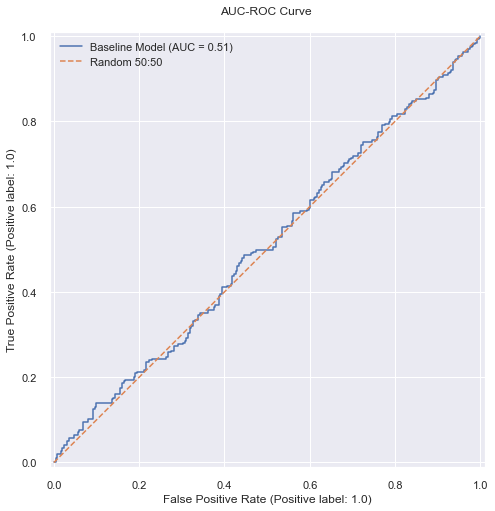

In [42]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
lr_classifier,
X_test,
y_test,
name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

The ROC curve for the baseline Logistic Regression model shows an AUC (Area Under the Curve) of 0.51, which is very close to the AUC of a random classifier (0.50). This indicates that the model has limited ability to distinguish between the two classes.

<strong> Classification Report    </strong>

A classification report is used to measure the quality of predictions from
a classification algorithm.

In [43]:
 # Classification Report
print(classification_report(y_test, lr_classifier.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.50      0.57      0.53       251
         1.0       0.53      0.46      0.49       263

    accuracy                           0.51       514
   macro avg       0.51      0.51      0.51       514
weighted avg       0.51      0.51      0.51       514



The model shows nearly balanced performance between the classes but with moderate effectiveness.
Both precision and recall are relatively low, suggesting the model struggles to correctly classify positive and negative returns reliably. F1-scores close to 50% for both classes indicate the model's limited capability in balancing precision and recall, which aligns with the ROC AUC score observed earlier.

<strong> Analyse Coefficents    </strong>

In [44]:
logistic_regression_model = lr_classifier.named_steps['lr_classifier']
coefficients = logistic_regression_model.coef_


feature_names = X.columns  
coefficients_df = pd.DataFrame(coefficients, columns=feature_names, index=['Coefficients']).T
print(coefficients_df)

             Coefficients
RET             -0.009097
ret_1            0.079601
ret_2            0.014007
ret_3            0.001397
OC               0.017393
HC              -0.048301
GAP             -0.012706
VCHG             0.124850
MA              -0.138792
VMA             -0.116697
STD              0.033880
Change_2yr      -0.035521
Change_10yr     -0.042738


VCHG, which measures volume change, has the most significant positive coefficient, suggesting that higher volume changes might be associated with positive market moves.
Both Change_2yr and Change_10yr rates show negative coefficients, indicating these features might predict negative returns or less likelihood of positive returns, whicj is to be expected.

##   5.1 Base Model SVM  

### Theoretical background for Support Vector Machines

#### Hard Margin

If the training data is linearly separable, we can select two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible.

Objective function:
$$
\frac{1}{2}||w||^{2}  \longrightarrow \min\limits_{w, b} 
$$

Subject to:
$$
y_i (w^T x_i + b) \geq 1 
$$

#### Soft Margin

When the data is not linearly separable, we need somehow allow the algorithm to cope with this problem. Therefore, we introduce $\xi_i$ term and put it both in the optimization function and constraint. In our optimization function, we also see hyperparameter $C$ to account for $\xi_i$.

Objective function:
$$
\frac{1}{2}||w||^{2} + C \sum_{i=1}^l \xi_i   \longrightarrow \min\limits_{w,b, \xi}
$$

Subject to:
$$
y_i (w^T x_i + b ) \geq 1 - \xi_i 
$$
$$
\xi_i \geq 0 \quad 
$$


In [45]:
# Define the SVM model using a pipeline
svm_classifier = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_classifier", SVC(kernel='linear', class_weight= "balanced", probability=True))
])

In [46]:
# Fit the model on the training data
svm_classifier.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_classifier',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

In [47]:
# Predict on the testing data
y_pred = svm_classifier.predict(X_test)

In [48]:
# Verify Class Labels
svm_classifier.classes_

array([0., 1.])

In [49]:
# Predict the Class Labels
y_pred = svm_classifier.predict(X_test)

In [50]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5175097276264592


The accuracy of the SVM model on the test data is approximately 51.76%. This suggests that the model performs marginally better than a random guess in a binary classification task and slightly better than the logistic regression model.

#### Prediction Quality

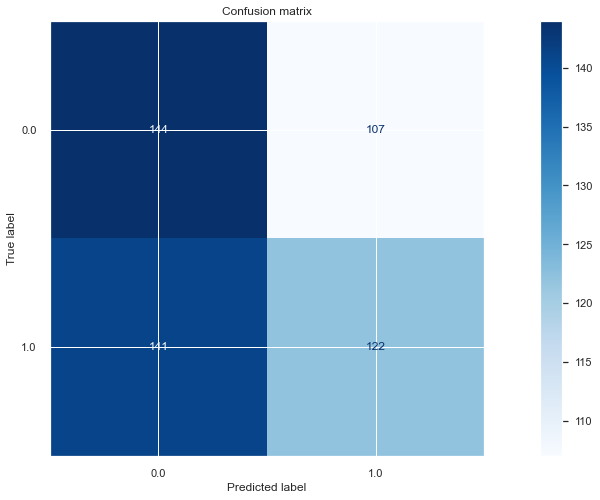

In [51]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
svm_classifier,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

The model is performing better in identifying true negatives and positives compared to the Logistic Regression model, particularly in reducing false negatives. However, the number of false positives remains high, indicating a tendency to over-predict the positive class. This indicates that while the SVM might be slightly more effective in certain areas than the Logistic Regression model, the overall predictive power remains moderate.

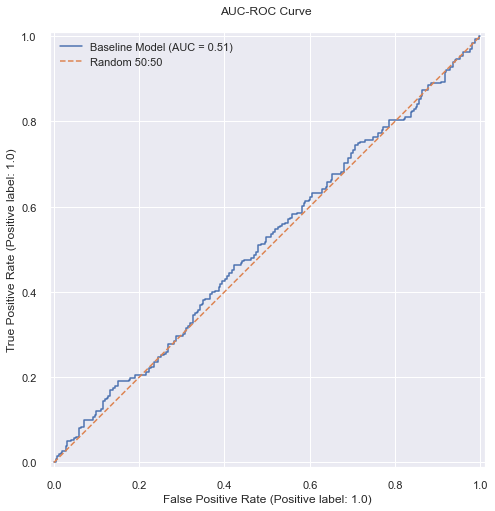

In [52]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
svm_classifier,
X_test,
y_test,
name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

The ROC curve for the base SVM model indicates an AUC of 0.51, which is practically equivalent to the performance of a random classifier (AUC = 0.50). This outcome highlights that the SVM model, like the previously tested Logistic Regression model, struggles to distinguish effectively between the two classes.

In [53]:
 # Classification Report
print(classification_report(y_test, svm_classifier.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.51      0.57      0.54       251
         1.0       0.53      0.46      0.50       263

    accuracy                           0.52       514
   macro avg       0.52      0.52      0.52       514
weighted avg       0.52      0.52      0.52       514



The model shows balanced but modest performance across both classes. Precision and recall are almost balanced, but they indicate limited predictive capability.

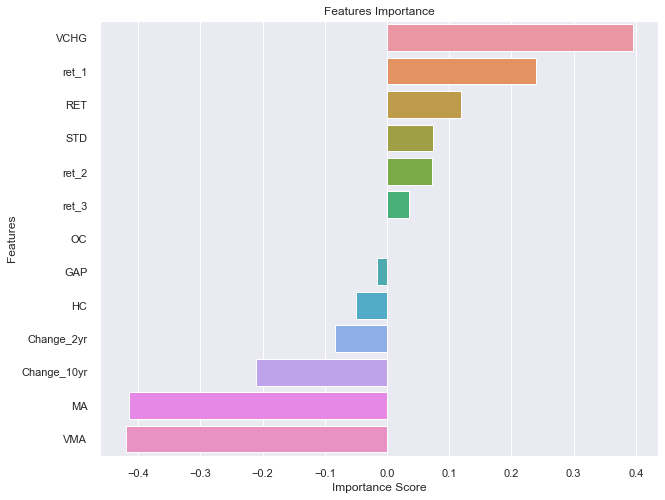

In [54]:
# Extract coefficients from the linear SVM
feature_importances = svm_classifier.named_steps['svm_classifier'].coef_[0]

#DataFrame to hold coefficients
feature_imp = pd.DataFrame({
    'Importance Score': feature_importances,
    'Features': X_train.columns
}).sort_values(by='Importance Score', ascending=False)

# Plot coefficients
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Importance Score', y='Features', data=feature_imp)
ax.set_title('Features Importance')
plt.show()


# 6. Hyperparameter Tuning   

### 6.1 Optuna

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they
are passed as arguments to the constructor of the estimator classes. It is possible and recommended
to search the hyper-parameter space for the best cross validation score. Any parameter provided
when constructing an estimator may be optimized in this manner.

For SVM classifiers, the most important areas to tune are:

- Kernel Type: Linear, RBF, Polynomial, Sigmoid.
- C (Regularization Parameter): Controls trade-off between achieving a low error on training data and minimizing the model complexity.
- Gamma (Kernel Coefficient for RBF, Polynomial, Sigmoid): Defines how far the influence of a single training example reaches.
- Degree (for Polynomial Kernel): Controls the complexity of the decision boundary for polynomial kernels.

In [55]:
# Get Params list
svm_classifier.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('svm_classifier',
   SVC(class_weight='balanced', kernel='linear', probability=True))],
 'verbose': False,
 'scaler': StandardScaler(),
 'svm_classifier': SVC(class_weight='balanced', kernel='linear', probability=True),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'svm_classifier__C': 1.0,
 'svm_classifier__break_ties': False,
 'svm_classifier__cache_size': 200,
 'svm_classifier__class_weight': 'balanced',
 'svm_classifier__coef0': 0.0,
 'svm_classifier__decision_function_shape': 'ovr',
 'svm_classifier__degree': 3,
 'svm_classifier__gamma': 'scale',
 'svm_classifier__kernel': 'linear',
 'svm_classifier__max_iter': -1,
 'svm_classifier__probability': True,
 'svm_classifier__random_state': None,
 'svm_classifier__shrinking': True,
 'svm_classifier__tol': 0.001,
 'svm_classifier__verbose': False}

In [56]:
# Use Optuna for Tuning
import optuna

In [57]:
def optimize(trial, x, y):
    # Specify parameter ranges
    C = trial.suggest_float("C", 0.01, 10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

    if kernel in ['rbf', 'poly', 'sigmoid']:
        gamma = trial.suggest_float("gamma", 1e-6, 1e2, log=True)
    else:
        gamma = 'scale'  

    # Create the SVM model pipeline
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, probability=True, class_weight='balanced'))
    ])

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=4, gap=1)
    ll = []

    for train_idx, test_idx in tscv.split(x):
        xtrain, xtest = x.iloc[train_idx], x.iloc[test_idx]
        ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        ll.append(log_loss(ytest, preds))

    return np.mean(ll)

In [58]:
# Create a Study
study = optuna.create_study(
study_name='hp_svm',
direction='minimize'
)

[I 2024-06-11 20:50:45,793] A new study created in memory with name: hp_svm


In [59]:
# Specify Optimization function
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20)

[I 2024-06-11 20:50:47,680] Trial 0 finished with value: 19.725644617923276 and parameters: {'C': 0.034217811764081556, 'kernel': 'poly', 'gamma': 0.03615098730411588}. Best is trial 0 with value: 19.725644617923276.
[I 2024-06-11 20:50:53,507] Trial 1 finished with value: 18.092087227480828 and parameters: {'C': 6.613958556175936, 'kernel': 'linear'}. Best is trial 1 with value: 18.092087227480828.
[I 2024-06-11 20:50:55,595] Trial 2 finished with value: 18.09208722748083 and parameters: {'C': 0.2557480981774948, 'kernel': 'linear'}. Best is trial 1 with value: 18.092087227480828.
[I 2024-06-11 20:50:58,492] Trial 3 finished with value: 17.494872697641654 and parameters: {'C': 0.5687022052679156, 'kernel': 'sigmoid', 'gamma': 0.0001889631855119411}. Best is trial 3 with value: 17.494872697641654.
[I 2024-06-11 20:51:00,473] Trial 4 finished with value: 18.337999092708724 and parameters: {'C': 0.016485578207749263, 'kernel': 'linear'}. Best is trial 3 with value: 17.494872697641654.
[I

In [60]:
 # Get the Best Params
print(f'Best Params: {study.best_params}, Best Value: {study.best_value}')

Best Params: {'C': 7.9626081862519795, 'kernel': 'rbf', 'gamma': 64.59502846831433}, Best Value: 16.353139037655


### Visualize Optimization

In [61]:
 # plot Optimization History
optuna.visualization.plot_optimization_history(study)

The optimization history plot shows a significant reduction in the objective value (loss) within the first few trials, indicating that the model parameters quickly converged to a better solution. 

In [62]:
# Plot Param Importances
optuna.visualization.plot_param_importances(study)

The plot shows that the kernel choice is significantly more important (0.55) than the regularization parameter 𝐶  (0.45) for the SVM model's performance. We should focus on tuning the kernel type for better results.

In [63]:
 # plot accuracies for each HP trail
optuna.visualization.plot_slice(study)


The slice plot shows how the objective value (log loss) changes with different values of hyperparameters (C, gamma, and kernel).

- For C, values around 0.1 and 0.01 tend to have better objective values (lower log loss).
- For gamma, smaller values (1e-5) tend to perform better.
- For kernel, the 'rbf' kernel shows better performance compared to 'linear', 'poly', and 'sigmoid'.
These insights help in understanding the impact of each hyperparameter on the model's performance.

In [64]:
 # plot the surface
optuna.visualization.plot_contour(study, params=['gamma','C'])

The contour plot shows the interaction between the hyperparameters C and gamma and their impact on the objective value (log loss).Darker regions represent better performance (lower log loss).The best performance is found at low values of gamma and moderate values of C.This visualization helps in identifying the optimal ranges for C and gamma for tuning the SVM model.

In [65]:
 # plot parallel coordinates
optuna.visualization.plot_parallel_coordinate(study)

The parallel coordinate plot visualizes the relationship between the hyperparameters (𝐶, gamma, kernel) and the objective value. Each line represents a trial with its corresponding hyperparameter values and resulting objective value. Darker lines indicate better performance (lower log loss).
The plot helps to see how different combinations of hyperparameters influence the model's performance.

## 6.1  Tuned Model  

We now build a tuned model with the best parameters using Pipelines. Dataset needs to be scaled
for the model to work properly and all the features should have a similar scale. The scaling can be
accomplished by using the StandardScaler.

In [66]:
# Scale and fit the model
SVM_opt = Pipeline([
    ("scaler", StandardScaler()),
    ("estimator", SVC(
        kernel=study.best_params['kernel'],
        C=study.best_params['C'],
        class_weight='balanced',
        probability=True
    ))
])

# Fit the model on the training data
SVM_opt.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 SVC(C=7.9626081862519795, class_weight='balanced',
                     probability=True))])

In [67]:
# Predict Class Labels
y_pred = SVM_opt.predict(X_test)

# Measure Accuracy
acc_train = accuracy_score(y_train, SVM_opt.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t:{acc_test :0.4}')


 Training Accuracy 	: 0.6928 
 Test Accuracy 		:0.5039


#### Preditction Quality

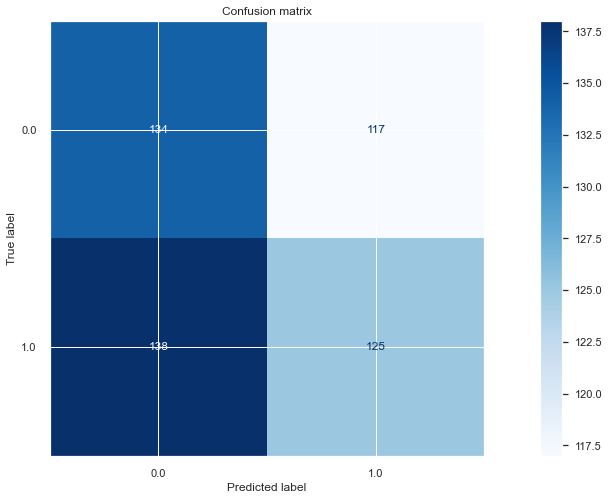

In [68]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
SVM_opt,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

The tuned SVM model has similar issues as the baseline model, with accuracy around 50% and an even distribution of misclassifications.

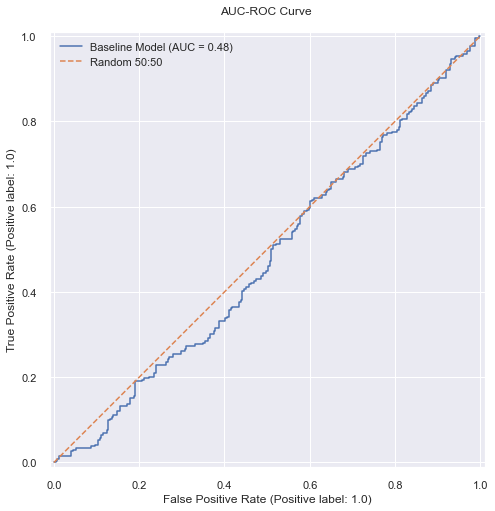

In [69]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
SVM_opt,
X_test,
y_test,
name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

The model does not provide a meaningful improvement over random guessing, as shown by the AUC of 0.50.

In [70]:
 # Classification Report
print(classification_report(y_test, SVM_opt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.49      0.53      0.51       251
         1.0       0.52      0.48      0.50       263

    accuracy                           0.50       514
   macro avg       0.50      0.50      0.50       514
weighted avg       0.50      0.50      0.50       514



The precision, recall, and F1-score are around 0.50 for both classes, indicating that the model's performance is close to random guessing.

## 6.2 Gridsearch Tuning

In [71]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [72]:
param_grid = {
    'svm_classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm_classifier__C': [0, 10],
    'svm_classifier__gamma': ['scale', 'auto'],
    'svm_classifier__degree': list(range(1, 3))
}


In [73]:
# perform random search
rs = RandomizedSearchCV(svm_classifier, param_grid, n_iter=100, scoring='f1', cv=tscv, verbose=0)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_classifier',
                                              SVC(class_weight='balanced',
                                                  kernel='linear',
                                                  probability=True))]),
                   n_iter=100,
                   param_distributions={'svm_classifier__C': [0, 10],
                                        'svm_classifier__degree': [1, 2],
                                        'svm_classifier__gamma': ['scale',
                                                                  'auto'],
                                        'svm_classifier__kernel': ['linear',
                                                                   'poly',
                                                                   'rbf',
                                                                   'sigmoid']},
                   scoring='f1')

In [74]:
# best parameters
rs.best_params_

{'svm_classifier__kernel': 'sigmoid',
 'svm_classifier__gamma': 'scale',
 'svm_classifier__degree': 1,
 'svm_classifier__C': 10}

In [75]:
# best score
rs.best_score_

0.5274990410212583

In [76]:
# Extract best parameters 
best_params_corrected = {k.replace('svm_classifier__', ''): v for k, v in rs.best_params_.items()}

# Create and train the SVC model with the corrected parameters
cls = SVC(**best_params_corrected)
cls.fit(X_train, y_train)

SVC(C=10, degree=1, kernel='sigmoid')

In [77]:
# Cross validation score
score = cross_val_score(cls,X_train,y_train,cv=tscv)
print(f'Mean CV Score : {score.mean():0.4}')

Mean CV Score : 0.5058


The mean CV score of 0.5058 indicates that the model's performance is slightly above random guessing.

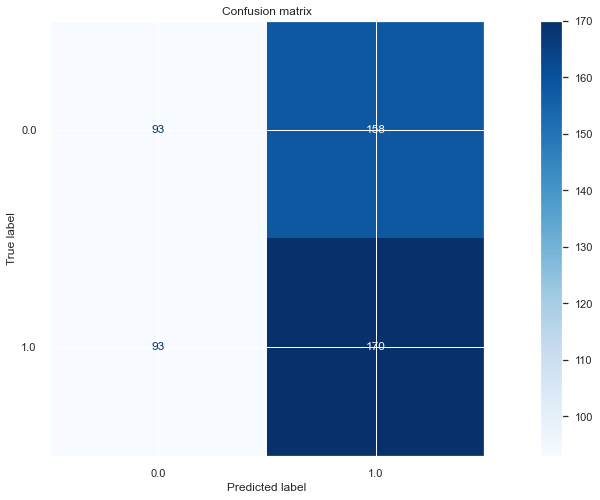

In [78]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
cls,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

The confusion matrix indicates that the model has a balanced rate of true positive and true negative predictions, but it also misclassifies a significant number of samples in both classes, similar to previous itterations. 

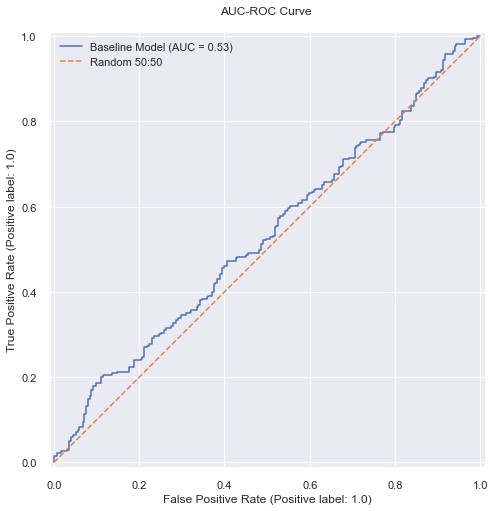

In [79]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
cls,
X_test,
y_test,
name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

The ROC curve shows that the model has an AUC of 0.53, which is only slightly better than random guessing (AUC of 0.50). This indicates that the model has limited ability to distinguish between the two classes.

### Summary

- Logistic Regression and Base SVM: Both models performed similarly, with a slight edge to Logistic Regression in terms of test accuracy.
- Optuna Tuned SVM: Did not show significant improvement over the baseline models, indicating limited effectiveness of the tuning parameters. 
- GridSearch Tuned SVM: Slightly better performance than other models with a mean CV score of 0.5058 and test accuracy of 0.5275, but still relatively close to random guessing.

The SPY financial data's normal distribution and inherent randomness present significant obstacles to accurate forecasting. While advanced models and feature engineering can offer some improvements, the unpredictable nature of market influences often limits the effectiveness of these efforts. 

## 6.3 Feature Reduction

In [80]:
# Select the top 5 features with the largest coefficients in absolute terms
top_features = ['VCHG', 'ret_1', 'VMA', 'MA', 'RET']

# Filter the dataset to include only the top 5 features
X_top_features = X[top_features]

In [81]:
# Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2,shuffle=False)

In [82]:
# Define the SVM model using a pipeline
svm_classifier2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_classifier", SVC(kernel='linear', class_weight='balanced', probability=True))
])

In [83]:
# Fit the model on the training data
svm_classifier2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_classifier',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

In [84]:
# Predict on the testing data
y_pred = svm_classifier2.predict(X_test)

In [85]:
# Verify Class Labels
svm_classifier2.classes_

array([0., 1.])

In [86]:
# Predict the Class Labels
y_pred = svm_classifier2.predict(X_test)

In [87]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.4980544747081712


It looks like the model accuracy is approximately 0.498 which is below 0.50 and indicates that the model is not performing better than random guessing. Same issue persists after feature reduction. There is no material improvement running the model with less features from the selection we have.

In [88]:
X_top_features

,VCHG,ret_1,VMA,MA,RET
Date,,,,,
2014-01-13,0.469149,0.002719,1.467993,0.992284,-0.013394
2014-01-14,-0.299388,-0.013394,0.995585,1.002487,0.010839
2014-01-15,-0.061803,0.010839,0.946232,1.006087,0.005376
2014-01-16,-0.266277,0.005376,0.707724,1.004044,-0.001301
2014-01-17,0.491877,-0.001301,1.039458,0.999704,-0.004238
...,...,...,...,...,...
2024-03-20,0.145490,0.005542,0.861899,1.010198,0.009207
2024-03-21,-0.134184,0.009207,0.763618,1.012016,0.003299
2024-03-22,0.311452,0.003299,0.959883,1.008634,-0.001898


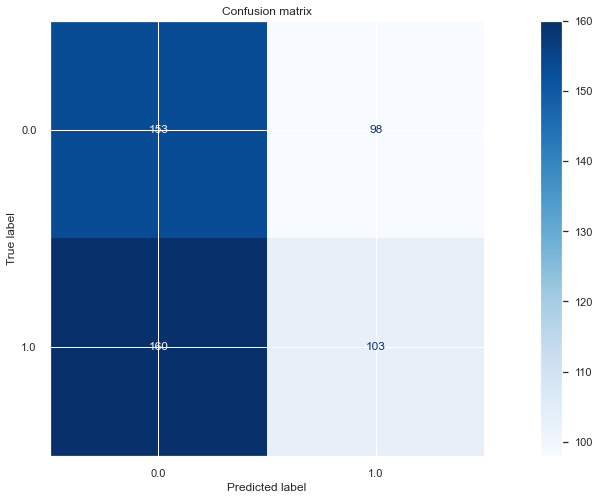

In [89]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
svm_classifier2,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

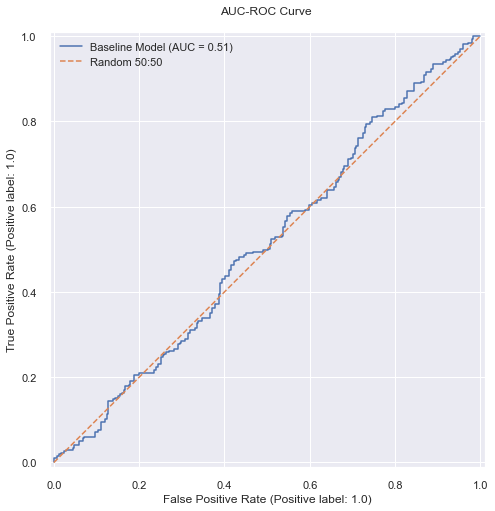

In [92]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
svm_classifier2,
X_test,
y_test,
name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [93]:
 # Classification Report
print(classification_report(y_test, svm_classifier2.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.49      0.61      0.54       251
         1.0       0.51      0.39      0.44       263

    accuracy                           0.50       514
   macro avg       0.50      0.50      0.49       514
weighted avg       0.50      0.50      0.49       514



## 7 Trading Strategy 

Let’s now define a trading strategy. We will use the predicted signals for trades. We then compare
the result of this strategy with the buy and hold and visualize the performance of the strategy built
using SVM. We will use the GridSearch Tuned SVM to create the signals as it had a slightly better performance than other models with a mean CV score of 0.5058 and test accuracy of 0.5275.

[*********************100%%**********************]  1 of 1 completed


Length of df2: 2568, Length of X: 2568


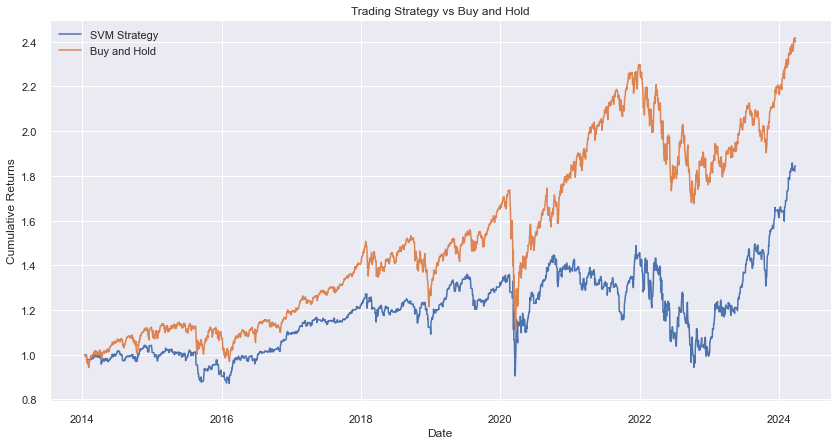

In [90]:


df2 = yf.download('SPY', start='2014-01-01', end='2024-03-31', period='1d')
df2 = df2.iloc[9:,:]  # Adjusting to match the prediction period

# Check lengths of df2
print(f"Length of df2: {len(df2)}, Length of X: {len(X)}")

# Get Prediction
df2['Signal'] = cls.predict(X)
# Define Entry Logic
df2['Entry'] = np.where(df2['Signal'] == 1, df2['Close'], 0)
# Defining Exit Logic
df2['Exit'] = np.where(df2['Entry'] != 0, df2['Close'].shift(-1), 0)

# Calculate (MTM)
df2['P&L'] = df2['Exit'] - df2['Entry']
# Generate Equity Curve
df2['Equity'] = df2['P&L'].cumsum() + df2['Close'][0]

# Calculate Benchmark Return
df2['Returns'] = np.log(df2['Close'] / df2['Close'].shift(1)).fillna(0)
# Calculate Strategy Return
df2['Strategy'] = df2['Equity'] / df2['Equity'].shift(1) - 1
df2['Strategy'] = df2['Strategy'].fillna(0)

# Generate Cumulative Returns for Buy and Hold Strategy
df2['Cumulative_Buy_Hold_Returns'] = (1 + df2['Returns']).cumprod()
# Generate Cumulative Returns for Trading Strategy
df2['Cumulative_Strategy_Returns'] = (1 + df2['Strategy']).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df2['Cumulative_Strategy_Returns'], label='SVM Strategy')
plt.plot(df2['Cumulative_Buy_Hold_Returns'], label='Buy and Hold')
plt.title('Trading Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()




The SVM strategy's cumulative returns are consistently lower than the buy-and-hold returns. This suggests that the model is not effectively predicting profitable trades, possibly due to the inherent randomness and challenges in forecasting financial data. The buy-and-hold strategy, despite being simpler, yielded better returns.

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.58,2021-12-14,2022-10-13,2023-08-28,445
1,33.45,2019-07-12,2020-03-20,2020-08-31,297
2,19.95,2020-10-12,2021-09-29,2021-12-09,304
3,16.42,2014-11-21,2016-02-10,2016-11-07,512
4,14.19,2018-01-30,2019-01-02,2019-03-28,303


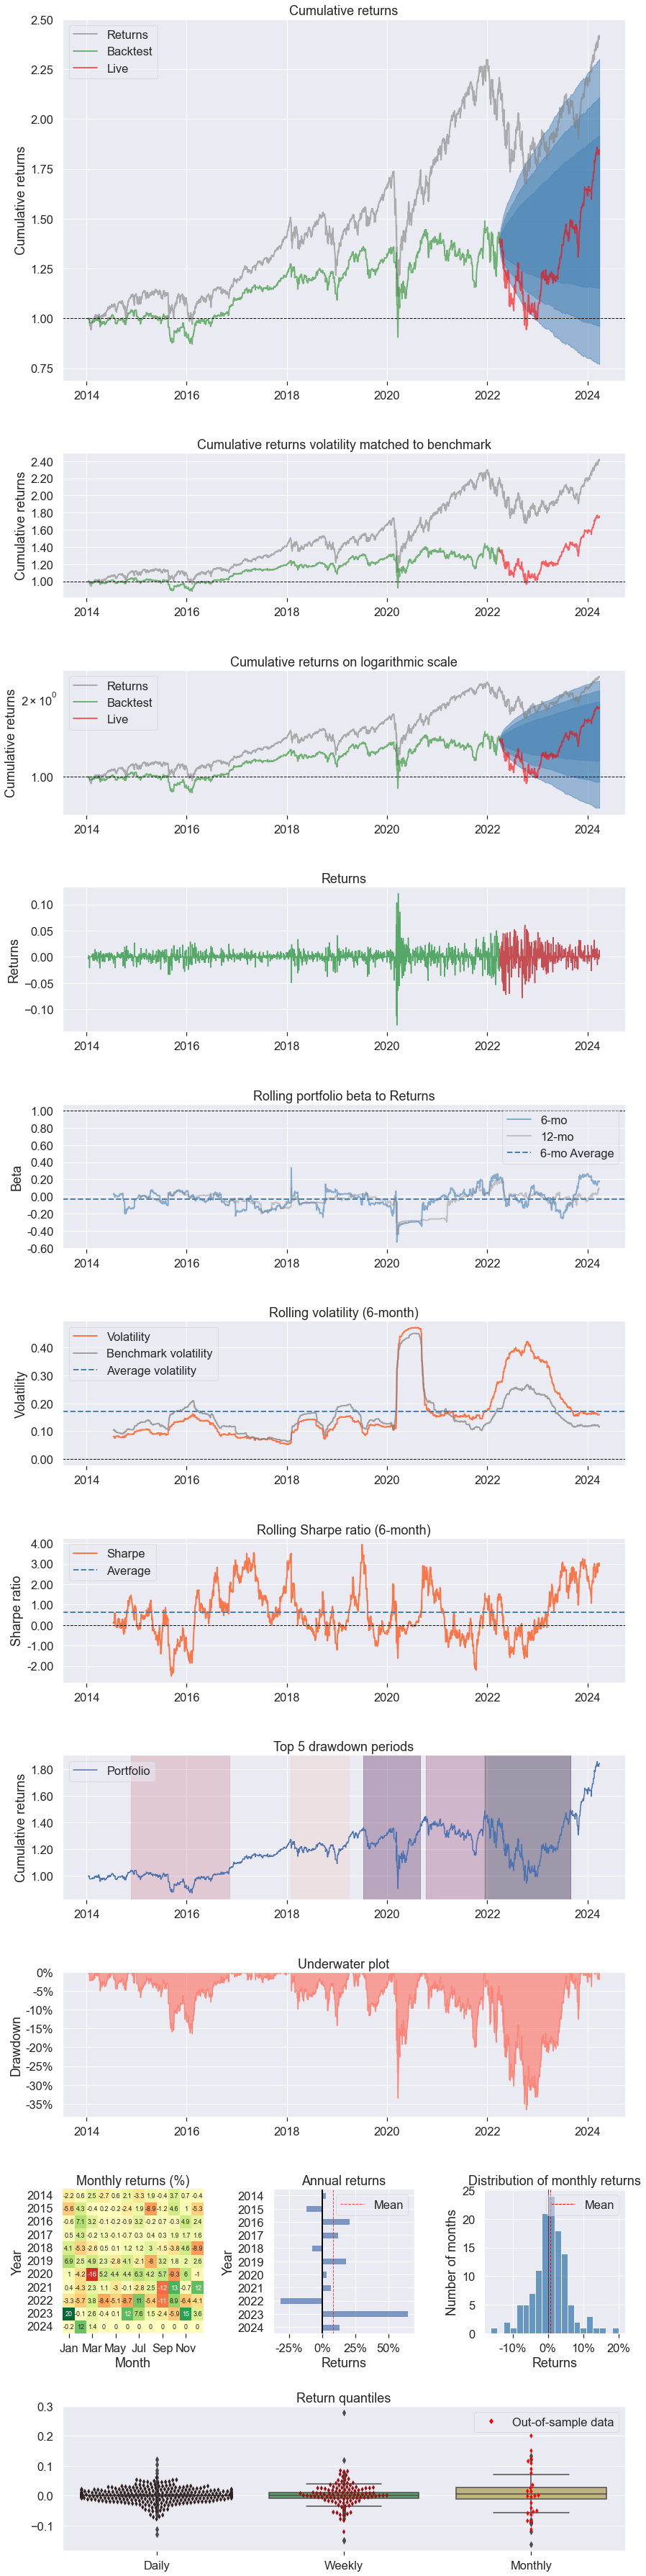

In [91]:
 # Can also use pyfolio for analysis
import pyfolio as pf
df3 = df2.copy()
df3.index = df3.index.tz_localize('utc')
pf.create_returns_tear_sheet(df3['Strategy'], live_start_date='2022-04-01',benchmark_rets=df3['Returns'])

The SVM trading strategy, despite its sophisticated approach, fails to outperform the simpler Buy and Hold strategy. It not only yields lower returns but also exposes investors to higher risk and more significant drawdowns. This analysis underscores the difficulty of forecasting financial markets and suggests that more straightforward investment strategies may be more effective for achieving steady growth.

# Conclusion

In this project, we set out to develop and evaluate machine learning models, specifically Logistic Regression and Support Vector Machines (SVM), to predict financial market trends and devise a trading strategy. Despite thorough model tuning and optimization using techniques like Optuna and GridSearch, the models struggled to outperform the simple Buy and Hold strategy.

- Model Performance: Both Logistic Regression and SVM models demonstrated limited predictive power, with accuracies hovering around 50%, indicating their predictions were not much better than random guessing.
- Trading Strategy: The SVM-based trading strategy underperformed significantly compared to the Buy and Hold strategy, both in terms of cumulative returns and risk-adjusted metrics.
- Market Complexity: The financial data's inherent randomness and normal distribution patterns posed substantial challenges, highlighting the difficulty in forecasting market movements accurately.

Overall, the project underscores the complexity of financial markets and the limitations of machine learning models in predicting market trends. While machine learning offers powerful tools for analysis, simpler investment strategies like Buy and Hold may still be more effective for long-term growth. I guess the old saying stands true, Time in the market beeats timing the market".

However, we could consider some procedures for feature selection like PCA or more complex modelling, but due to the shortage of time, we did not do this (potential area to test). 